# Capacity Raing imputation methods

In [1]:
# import libraries
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# imputation methods
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from scipy.spatial import distance
from shapely.geometry import MultiPolygon, Polygon, Point
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

### import the datasets

In [2]:
# import split datasets

train_ESA = gpd.read_file('train_ESA.gpkg')
val_ESA = gpd.read_file('val_ESA.gpkg')
test_ESA = gpd.read_file('test_ESA.gpkg')

# Display the rows
print(train_ESA.shape[0])
print(val_ESA.shape[0])
print(test_ESA.shape[0])

3303
708
708


In [3]:
# Function to evaluate the results
def evaluate_imputation(original, imputed):
    rmse = np.sqrt(mean_squared_error(original, imputed))
    mae = mean_absolute_error(original, imputed)
    mape = mean_absolute_percentage_error(original, imputed)*100
    return rmse, mae, mape

### 1. Mean/Median/Mode imputation

In [4]:
target = 'CapacityRating'
mean_value = train_ESA[target].mean()
median_value = train_ESA[target].median()
mode_value = train_ESA[target].mode().iloc[0]

print("The description in Capacity Rating")
print(" ")
print(f"  Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"  Mode: {mode_value}")

The description in Capacity Rating
 
  Mean: 272.5643354526188
Median: 200.0
  Mode: 500.0


In [5]:
train_capacity = train_ESA[[target]]
val_capacity = val_ESA[[target]]

# Copy from original val set
val_mean_imputed = val_capacity.copy()
val_median_imputed = val_capacity.copy()
val_mode_imputed = val_capacity.copy()

# Impute with calculated statistics
val_mean_imputed[target] = mean_value
val_median_imputed[target] = median_value
val_mode_imputed[target] = mode_value

rmse_mean, mae_mean, mape_mean = evaluate_imputation(val_capacity, val_mean_imputed[[target]])
rmse_median, mae_median, mape_median = evaluate_imputation(val_capacity, val_median_imputed[[target]])
rmse_mode, mae_mode, mape_mode = evaluate_imputation(val_capacity, val_mode_imputed[[target]])

# Print results
print(f"RMSE (Mean Imputation)  : {rmse_mean}")
print(f"MAE  (Mean Imputation)  : {mae_mean}")
print(f"MAPE (Mean Imputation)  : {mape_mean}")
print(" ")
print(f"RMSE (Median Imputation): {rmse_median}")
print(f"MAE  (Median Imputation): {mae_median}")
print(f"MAPE (Median Imputation): {mape_median}")
print(" ")
print(f"RMSE (Mode Imputation)  : {rmse_mode}")
print(f"MAE  (Mode Imputation)  : {mae_mode}")
print(f"MAPE (Mode Imputation)  : {mape_mode}")

RMSE (Mean Imputation)  : 245.90126094568623
MAE  (Mean Imputation)  : 202.96643352815704
MAPE (Mean Imputation)  : 328.62418690063436
 
RMSE (Median Imputation): 254.386900046473
MAE  (Median Imputation): 189.98870056497177
MAPE (Median Imputation): 236.3784638149045
 
RMSE (Mode Imputation)  : 339.69450382984326
MAE  (Mode Imputation)  : 293.64689265536725
MAPE (Mode Imputation)  : 633.9714487489911


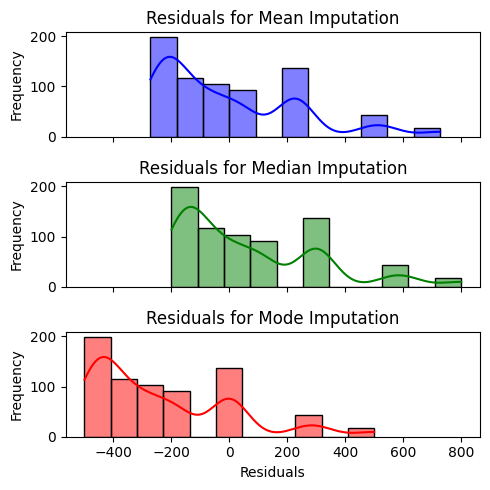

In [6]:
# Calculate residuals
residuals_mean = val_capacity[target] - val_mean_imputed[target]
residuals_median = val_capacity[target] - val_median_imputed[target]
residuals_mode = val_capacity[target] - val_mode_imputed[target]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True)

# Mean
sns.histplot(residuals_mean, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for Mean Imputation')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# Median
sns.histplot(residuals_median, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for Median Imputation')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Mode
sns.histplot(residuals_mode, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for Mode Imputation')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2. KNN imputation

In [7]:
target = 'CapacityRating'

conti_features = ['Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 'Consumption_postcode', 
                  'Population_building', 'building_density_number', 'All building_num']


In [8]:
# Normalise features
scaler = StandardScaler()
train_conti_scaled = scaler.fit_transform(train_ESA[conti_features])
val_conti_scaled = scaler.transform(val_ESA[conti_features])

# Add the target column
train_scaled_with_target = np.concatenate([train_conti_scaled, train_ESA[[target]].values.reshape(-1, 1)], axis=1)
val_scaled_with_target = np.concatenate([val_conti_scaled, val_ESA[[target]].values.reshape(-1, 1)], axis=1)

# Convert to df
train_scaled_df = pd.DataFrame(train_scaled_with_target, columns=conti_features + [target])
val_scaled_df = pd.DataFrame(val_scaled_with_target, columns=conti_features + [target])

In [9]:
# Citation: Scikit-learn developers, KNNImputer.
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

# Function to perform KNN Imputation
def impute_knn(target, n):
    
    # Prepare the val datasets
    val_scaled_df[target] = np.nan
    
    # KNN imputation
    imputer = KNNImputer(n_neighbors=n)
    imputer.fit(train_scaled_df)
    val_imputed = imputer.transform(val_scaled_df)
    
    return val_imputed

# Apply the KNN imputer
val2_K3 = impute_knn(target, 3)
val2_K5 = impute_knn(target, 5)
val2_K7 = impute_knn(target, 7)
val2_K9 = impute_knn(target, 9)
val2_K11 = impute_knn(target, 11)

# Convert the numpy array back to a DataFrame
val_K3_df = pd.DataFrame(val2_K3, columns=conti_features + [target])
val_K5_df = pd.DataFrame(val2_K5, columns=conti_features + [target])
val_K7_df = pd.DataFrame(val2_K7, columns=conti_features + [target])
val_K9_df = pd.DataFrame(val2_K9, columns=conti_features + [target])
val_K11_df = pd.DataFrame(val2_K11, columns=conti_features + [target])

In [10]:
rmse_k3, mae_k3, mape_k3 = evaluate_imputation(val_ESA[target], val_K3_df[target])
rmse_k5, mae_k5, mape_k5 = evaluate_imputation(val_ESA[target], val_K5_df[target])
rmse_k7, mae_k7, mape_k7 = evaluate_imputation(val_ESA[target], val_K7_df[target])
rmse_k9, mae_k9, mape_k9 = evaluate_imputation(val_ESA[target], val_K9_df[target])
rmse_k11, mae_k11, mape_k11 = evaluate_imputation(val_ESA[target], val_K11_df[target])

# Print results
print(f"RMSE (K=3)  : {rmse_k3}")
print(f"MAE  (K=3)  : {mae_k3}")
print(f"MAPE (K=3)  : {mape_k3}")
print(" ")
print(f"RMSE (K=5)  : {rmse_k5}")
print(f"MAE  (K=5)  : {mae_k5}")
print(f"MAPE (K=5)  : {mape_k5}")
print(" ")
print(f"RMSE (K=7)  : {rmse_k7}")
print(f"MAE  (K=7)  : {mae_k7}")
print(f"MAPE (K=7)  : {mape_k7}")
print(" ")
print(f"RMSE (K=9)  : {rmse_k9}")
print(f"MAE  (K=9)  : {mae_k9}")
print(f"MAPE (K=9)  : {mape_k9}")
print(" ")
print(f"RMSE (K=11) : {rmse_k11}")
print(f"MAE  (K=11) : {mae_k11}")
print(f"MAPE (K=11) : {mape_k11}")
print(" ")

RMSE (K=3)  : 174.01642254974652
MAE  (K=3)  : 121.96233521657251
MAPE (K=3)  : 136.55112396496577
 
RMSE (K=5)  : 165.99179766679848
MAE  (K=5)  : 117.87711864406779
MAPE (K=5)  : 132.13980416554568
 
RMSE (K=7)  : 162.80851864629997
MAE  (K=7)  : 114.8724778046812
MAPE (K=7)  : 129.8772863900739
 
RMSE (K=9)  : 164.59332875213306
MAE  (K=9)  : 114.55430006277464
MAPE (K=9)  : 134.6206948305583
 
RMSE (K=11) : 163.516201957941
MAE  (K=11) : 114.5472521828454
MAPE (K=11) : 136.84241374601544
 


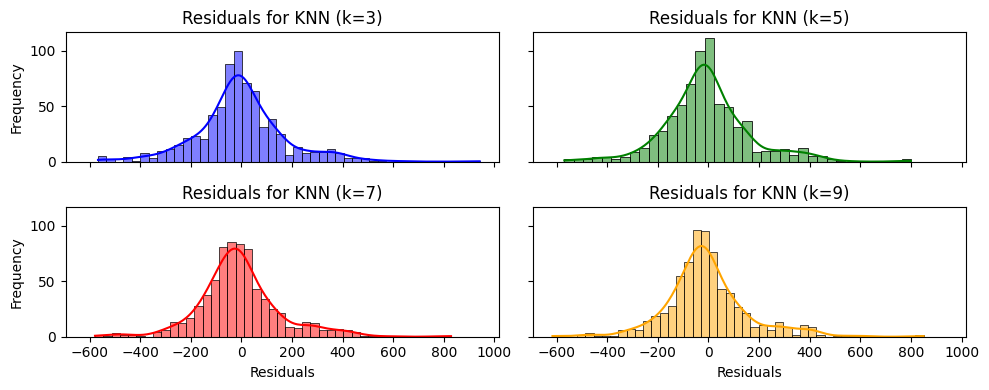

In [11]:
# Calculate residuals
residuals_K3 = val_ESA[target] - val_K3_df[target]
residuals_K5 = val_ESA[target] - val_K5_df[target]
residuals_K7 = val_ESA[target] - val_K7_df[target]
residuals_K9 = val_ESA[target] - val_K9_df[target]
residuals_K11 = val_ESA[target] - val_K11_df[target]

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
axs = ax.flatten()

# k=3
sns.histplot(residuals_K3, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for KNN (k=3)')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# k=5
sns.histplot(residuals_K5, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for KNN (k=5)')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# k=7
sns.histplot(residuals_K7, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for KNN (k=7)')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

# k=9
sns.histplot(residuals_K9, kde=True, color='orange', ax=axs[3])
axs[3].set_title('Residuals for KNN (k=9)')
axs[3].set_xlabel('Residuals')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3. Linear regression imputation

In [12]:
# Citation: GeeksforGeeks, Detecting Multicollinearity with VIF in Python. 
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

# Check for multicollinearity
df_features = pd.DataFrame(train_ESA, columns=conti_features)
vif = pd.DataFrame()
vif["Variable"] = df_features.columns
vif["VIF"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]

print(vif)

                              Variable        VIF
0  Non_Domestic_consumption_building_C   1.832562
1        Domestic_consumption_building   2.459996
2                 Consumption_postcode   8.485766
3                  Population_building   1.580534
4              building_density_number   2.559355
5                     All building_num  11.846292


In [13]:
new_features = ['Non_Domestic_consumption_building_C', 'Domestic_consumption_building', 'Consumption_postcode', 
                   'Population_building', 'building_density_number']#, 'All building_num']

# Check again for multicollinearity
df_features = pd.DataFrame(train_ESA, columns=new_features)
vif = pd.DataFrame()
vif["Variable"] = df_features.columns
vif["VIF"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]

print(vif)

                              Variable       VIF
0  Non_Domestic_consumption_building_C  1.666324
1        Domestic_consumption_building  2.390704
2                 Consumption_postcode  2.899786
3                  Population_building  1.535851
4              building_density_number  2.076258


In [14]:
# Citation: Scikit-learn, Linear Regression Example. 
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

# Train with low VIF features
model2 = LinearRegression()
model2.fit(train_ESA[new_features], train_ESA[[target]])
predictions2 = model2.predict(val_ESA[new_features])

# evaluation metric
rmse_reg2, mae_reg2, mape_reg2 = evaluate_imputation(val_ESA[target], predictions2)

# Print results
print(f"RMSE (Regression Imputation): {rmse_reg2}")
print(f"MAE  (Regression Imputation): {mae_reg2}")
print(f"MAPE (Regression Imputation): {mape_reg2}")

RMSE (Regression Imputation): 187.16775320271404
MAE  (Regression Imputation): 134.0963783619442
MAPE (Regression Imputation): 194.44233132667438


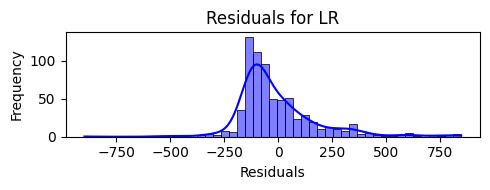

In [15]:
# Calculate residuals
residuals_LR = val_ESA[target] - predictions2.ravel()

# Plot residuals
fig, ax = plt.subplots(figsize=(5, 2))

sns.histplot(residuals_LR, kde=True, color='blue', ax=ax)
ax.set_title('Residuals for LR')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 4. RF imputation

In [16]:
# Citation: Scikit-learn, RandomForestRegressor. 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Prepare dataset
X_train = train_ESA[conti_features]
y_train = train_ESA[target]
X_val = val_ESA[conti_features]

# perform random forests
rf10_15 = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=24)
rf10_15.fit(X_train, y_train)
y_pred_rf10_15 = rf10_15.predict(X_val)

rf10_30 = RandomForestRegressor(n_estimators=10, max_depth=30, random_state=24)
rf10_30.fit(X_train, y_train)
y_pred_rf10_30 = rf10_30.predict(X_val)

rf100_15 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=24)
rf100_15.fit(X_train, y_train)
y_pred_rf100_15 = rf100_15.predict(X_val)

rf100_30 = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=24)
rf100_30.fit(X_train, y_train)
y_pred_rf100_30 = rf100_30.predict(X_val)

rf500_15 = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=24)
rf500_15.fit(X_train, y_train)
y_pred_rf500_15 = rf500_15.predict(X_val)

rf500_30 = RandomForestRegressor(n_estimators=500, max_depth=30, random_state=24)
rf500_30.fit(X_train, y_train)
y_pred_rf500_30 = rf500_30.predict(X_val)

In [17]:
rmse_rf10_15, mae_rf10_15, mape_rf10_15 = evaluate_imputation(val_ESA[target], y_pred_rf10_15)
rmse_rf10_30, mae_rf10_30, mape_rf10_30 = evaluate_imputation(val_ESA[target], y_pred_rf10_30)
rmse_rf100_15, mae_rf100_15, mape_rf100_15 = evaluate_imputation(val_ESA[target], y_pred_rf100_15)
rmse_rf100_30, mae_rf100_30, mape_rf100_30 = evaluate_imputation(val_ESA[target], y_pred_rf100_30)
rmse_rf500_15, mae_rf500_15, mape_rf500_15 = evaluate_imputation(val_ESA[target], y_pred_rf500_15)
rmse_rf500_30, mae_rf500_30, mape_rf500_30 = evaluate_imputation(val_ESA[target], y_pred_rf500_30)

# Print results
print(f"RMSE (rf10_15)  : {rmse_rf10_15}")
print(f"MAE  (rf10_15)  : {mae_rf10_15}")
print(f"MAPE (rf10_15)  : {mape_rf10_15}")
print(" ")
print(f"RMSE (rf10_30)  : {rmse_rf10_30}")
print(f"MAE  (rf10_30)  : {mae_rf10_30}")
print(f"MAPE (rf10_30)  : {mape_rf10_30}")
print(" ")
print(f"RMSE (rf100_15)  : {rmse_rf100_15}")
print(f"MAE  (rf100_15)  : {mae_rf100_15}")
print(f"MAPE (rf100_15)  : {mape_rf100_15}")
print(" ")
print(f"RMSE (rf100_30)  : {rmse_rf100_30}")
print(f"MAE  (rf100_30)  : {mae_rf100_30}")
print(f"MAPE (rf100_30)  : {mape_rf100_30}")
print(" ")
print(f"RMSE (rf500_15)  : {rmse_rf500_15}")
print(f"MAE  (rf500_15)  : {mae_rf500_15}")
print(f"MAPE (rf500_15)  : {mape_rf500_15}")
print(" ")
print(f"RMSE (rf500_30)  : {rmse_rf500_30}")
print(f"MAE  (rf500_30)  : {mae_rf500_30}")
print(f"MAPE (rf500_30)  : {mape_rf500_30}")

RMSE (rf10_15)  : 157.75011868711883
MAE  (rf10_15)  : 112.84846339606312
MAPE (rf10_15)  : 135.11859875944637
 
RMSE (rf10_30)  : 159.04480473556208
MAE  (rf10_30)  : 114.49881535524682
MAPE (rf10_30)  : 138.25530923052125
 
RMSE (rf100_15)  : 153.38618676772606
MAE  (rf100_15)  : 110.37323024898139
MAPE (rf100_15)  : 130.69893213503227
 
RMSE (rf100_30)  : 154.35924463215252
MAE  (rf100_30)  : 110.68512667945156
MAPE (rf100_30)  : 133.03250318637654
 
RMSE (rf500_15)  : 152.3195310673252
MAE  (rf500_15)  : 109.26542145299044
MAPE (rf500_15)  : 128.98864788581102
 
RMSE (rf500_30)  : 153.52212980115488
MAE  (rf500_30)  : 110.3119489476088
MAPE (rf500_30)  : 131.86875467105216


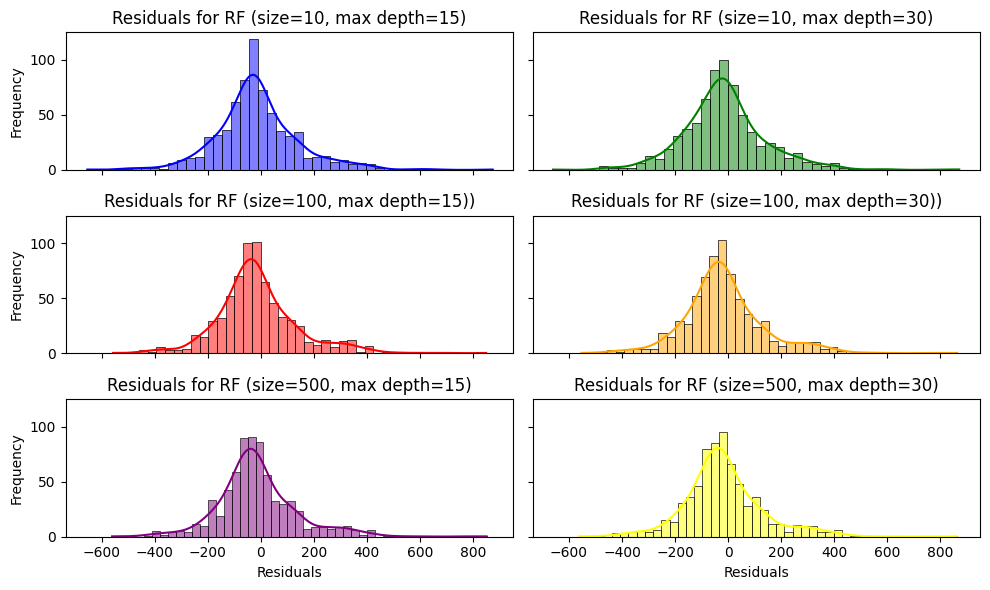

In [18]:
# Calculate residuals
residuals_rf10_15 = val_ESA[target] - y_pred_rf10_15
residuals_rf10_30 = val_ESA[target] - y_pred_rf10_30
residuals_rf100_15 = val_ESA[target] - y_pred_rf100_15
residuals_rf100_30 = val_ESA[target] - y_pred_rf100_30
residuals_rf500_15 = val_ESA[target] - y_pred_rf500_15
residuals_rf500_30 = val_ESA[target] - y_pred_rf500_30

# Create subplots
fig, ax = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = ax.flatten()

# n_estimators=10
sns.histplot(residuals_rf10_15, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for RF (size=10, max depth=15)')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

sns.histplot(residuals_rf10_30, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for RF (size=10, max depth=30)')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# n_estimators=100
sns.histplot(residuals_rf100_15, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for RF (size=100, max depth=15))')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

sns.histplot(residuals_rf100_30, kde=True, color='orange', ax=axs[3])
axs[3].set_title('Residuals for RF (size=100, max depth=30))')
axs[3].set_xlabel('Residuals')
axs[3].set_ylabel('Frequency')

# n_estimators=500
sns.histplot(residuals_rf500_15, kde=True, color='purple', ax=axs[4])
axs[4].set_title('Residuals for RF (size=500, max depth=15)')
axs[4].set_xlabel('Residuals')
axs[4].set_ylabel('Frequency')

sns.histplot(residuals_rf500_30, kde=True, color='yellow', ax=axs[5])
axs[5].set_title('Residuals for RF (size=500, max depth=30)')
axs[5].set_xlabel('Residuals')
axs[5].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 5. MLP imputation

In [19]:
# Normalise target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_ESA[[target]])

# Normalize continuous features
scaler_X = StandardScaler()
train_conti_scaled = scaler_X.fit_transform(train_ESA[conti_features])
val_conti_scaled = scaler_X.transform(val_ESA[conti_features])

In [20]:
# Citation: Scikit-learn, MLPRegressor. 
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

# Function to perform MLP Imputation
def impute_mlp_N(hiddensizes, lr):
    
    mlp = MLPRegressor(hidden_layer_sizes=hiddensizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=363, early_stopping=True, validation_fraction=0.1, 
                       learning_rate_init=lr)
    
    # Train the model
    mlp.fit(train_conti_scaled, y_train_scaled.ravel())
    
    # Predict on test data
    y_pred_scaled = mlp.predict(val_conti_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return y_pred

# Different settings
mlp_setting = [
    ((5, 5), 0.005),
    ((5, 5), 0.01),
    ((5, 5), 0.05),
    ((5, 5), 0.1),
    ((15, 15), 0.005),
    ((15, 15), 0.01),
    ((15, 15), 0.05),
    ((15, 15), 0.1),
    ((30, 30), 0.005),
    ((30, 30), 0.01),
    ((30, 30), 0.05),
    ((30, 30), 0.1),
]

results = {}

# Apply MLP and evaluate
for setting in mlp_setting:
    hiddensizes, lr = setting
    imputed_values = impute_mlp_N(hiddensizes, lr)
    rmse, mae, mape = evaluate_imputation(val_ESA[[target]], imputed_values)
    results[setting] = (rmse, mae, mape)

# Print the results
for setting, (rmse, mae, mape) in results.items():
    hiddensizes, lr = setting
    print(f"Hidden Sizes {hiddensizes}, lr {lr}:")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  MAPE : {mape:.2f}%")
    print(" ")

Hidden Sizes (5, 5), lr 0.005:
  RMSE : 156.13
  MAE  : 110.86
  MAPE : 127.01%
 
Hidden Sizes (5, 5), lr 0.01:
  RMSE : 154.23
  MAE  : 110.37
  MAPE : 131.36%
 
Hidden Sizes (5, 5), lr 0.05:
  RMSE : 154.63
  MAE  : 112.03
  MAPE : 128.70%
 
Hidden Sizes (5, 5), lr 0.1:
  RMSE : 158.27
  MAE  : 110.54
  MAPE : 114.27%
 
Hidden Sizes (15, 15), lr 0.005:
  RMSE : 171.88
  MAE  : 120.51
  MAPE : 150.46%
 
Hidden Sizes (15, 15), lr 0.01:
  RMSE : 155.34
  MAE  : 115.36
  MAPE : 155.77%
 
Hidden Sizes (15, 15), lr 0.05:
  RMSE : 159.23
  MAE  : 111.22
  MAPE : 124.46%
 
Hidden Sizes (15, 15), lr 0.1:
  RMSE : 163.10
  MAE  : 113.59
  MAPE : 130.25%
 
Hidden Sizes (30, 30), lr 0.005:
  RMSE : 154.71
  MAE  : 112.64
  MAPE : 141.19%
 
Hidden Sizes (30, 30), lr 0.01:
  RMSE : 153.00
  MAE  : 111.83
  MAPE : 143.08%
 
Hidden Sizes (30, 30), lr 0.05:
  RMSE : 155.18
  MAE  : 108.22
  MAPE : 124.66%
 
Hidden Sizes (30, 30), lr 0.1:
  RMSE : 160.37
  MAE  : 110.21
  MAPE : 109.30%
 


### 6. IDW imputation

In [21]:
target = 'CapacityRating'

# Extract centroids and values for training data
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_x = [centroid.x for centroid in train_centroids]
train_y = [centroid.y for centroid in train_centroids]
train_target = train_ESA[target]

# Extract centroids and values for validation data
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)

val_x = [centroid.x for centroid in val_centroids]
val_y = [centroid.y for centroid in val_centroids]
val_target = val_ESA[target]

In [22]:
# Citation: Pareekshith Katti, "Inverse Distance Weighting Interpolation in Python," Medium, 
# https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

# Function for idw imputation
def idw_interpolation(x, y, z, xi, yi, power=2):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    zi = np.zeros_like(xi)
    
    for i in range(len(xi)):
        dists = distance.cdist([(xi[i], yi[i])], list(zip(x, y)), 'euclidean')[0]
        if np.any(dists == 0):
            zi[i] = z[dists == 0][0]
        else:
            weights = 1 / dists**power
            weights /= weights.sum()
            zi[i] = np.dot(weights, z)
    
    return zi

# try different power with all data points
idw_pred_1 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, 1)
idw_pred_2 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, 2)
idw_pred_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, 3)

rmse_idw1, mae_idw1, mape_idw1 = evaluate_imputation(val_ESA[target], idw_pred_1)
rmse_idw2, mae_idw2, mape_idw2 = evaluate_imputation(val_ESA[target], idw_pred_2)
rmse_idw3, mae_idw3, mape_idw3 = evaluate_imputation(val_ESA[target], idw_pred_3)

# Print results
print(f"RMSE (IDW 1)  : {rmse_idw1}")
print(f"MAE  (IDW 1)  : {mae_idw1}")
print(f"MAPE (IDW 1)  : {mape_idw1}")
print(" ")
print(f"RMSE (IDW 2)  : {rmse_idw2}")
print(f"MAE  (IDW 2)  : {mae_idw2}")
print(f"MAPE (IDW 2)  : {mape_idw2}")
print(" ")
print(f"RMSE (IDW 3)  : {rmse_idw3}")
print(f"MAE  (IDW 3)  : {mae_idw3}")
print(f"MAPE (IDW 3)  : {mape_idw3}")

RMSE (IDW 1)  : 218.57494361182665
MAE  (IDW 1)  : 183.77130026661268
MAPE (IDW 1)  : 317.2307929870053
 
RMSE (IDW 2)  : 183.71639708600185
MAE  (IDW 2)  : 149.79745275521458
MAPE (IDW 2)  : 260.8158373920025
 
RMSE (IDW 3)  : 178.09744884892365
MAE  (IDW 3)  : 136.98381509342596
MAPE (IDW 3)  : 213.4460792920416


In [23]:
# Add the restriction of neighbour numbers
def idw_interpolation(x, y, z, xi, yi, power=2, n_neighbors=None):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    zi = np.zeros_like(xi)
    
    for i in range(len(xi)):
        # Calculate distances
        dists = distance.cdist([(xi[i], yi[i])], list(zip(x, y)), 'euclidean')[0]
        
        # Sort distances and select the nearest neighbors
        if n_neighbors is not None:
            idx = np.argsort(dists)[:n_neighbors]
            dists = dists[idx]
            z_subset = z[idx]
        else:
            z_subset = z
        
        # Handle cases
        if np.any(dists == 0):
            zi[i] = z_subset[dists == 0][0]
        else:
            weights = 1 / dists**power
            weights /= weights.sum()
            zi[i] = np.dot(weights, z_subset)
    
    return zi

# different number of power and nearest neighbours
n_neighbors = 3
idw_pred_1_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_3 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 5
idw_pred_1_5 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_5 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_5 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 7
idw_pred_1_7 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_7 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_7 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 9
idw_pred_1_9 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_9 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_9 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

n_neighbors = 11
idw_pred_1_11 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=1, n_neighbors=n_neighbors)
idw_pred_2_11 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=2, n_neighbors=n_neighbors)
idw_pred_3_11 = idw_interpolation(train_x, train_y, train_target, val_x, val_y, power=3, n_neighbors=n_neighbors)

In [24]:
rmse_idw13, mae_idw13, mape_idw13 = evaluate_imputation(val_ESA[target], idw_pred_1_3)
rmse_idw23, mae_idw23, mape_idw23 = evaluate_imputation(val_ESA[target], idw_pred_2_3)
rmse_idw33, mae_idw33, mape_idw33 = evaluate_imputation(val_ESA[target], idw_pred_3_3)

rmse_idw15, mae_idw15, mape_idw15 = evaluate_imputation(val_ESA[target], idw_pred_1_5)
rmse_idw25, mae_idw25, mape_idw25 = evaluate_imputation(val_ESA[target], idw_pred_2_5)
rmse_idw35, mae_idw35, mape_idw35 = evaluate_imputation(val_ESA[target], idw_pred_3_5)

rmse_idw17, mae_idw17, mape_idw17 = evaluate_imputation(val_ESA[target], idw_pred_1_7)
rmse_idw27, mae_idw27, mape_idw27 = evaluate_imputation(val_ESA[target], idw_pred_2_7)
rmse_idw37, mae_idw37, mape_idw37 = evaluate_imputation(val_ESA[target], idw_pred_3_7)

rmse_idw19, mae_idw19, mape_idw19 = evaluate_imputation(val_ESA[target], idw_pred_1_9)
rmse_idw29, mae_idw29, mape_idw29 = evaluate_imputation(val_ESA[target], idw_pred_2_9)
rmse_idw39, mae_idw39, mape_idw39 = evaluate_imputation(val_ESA[target], idw_pred_3_9)

rmse_idw111, mae_idw111, mape_idw111 = evaluate_imputation(val_ESA[target], idw_pred_1_11)
rmse_idw211, mae_idw211, mape_idw211 = evaluate_imputation(val_ESA[target], idw_pred_2_11)
rmse_idw311, mae_idw311, mape_idw311 = evaluate_imputation(val_ESA[target], idw_pred_3_11)

# Print results
print(f"RMSE (IDW 1,3)  : {rmse_idw13}")
print(f"MAE  (IDW 1,3)  : {mae_idw13}")
print(f"MAPE (IDW 1,3)  : {mape_idw13}")
print(" ")
print(f"RMSE (IDW 2,3)  : {rmse_idw23}")
print(f"MAE  (IDW 2,3)  : {mae_idw23}")
print(f"MAPE (IDW 2,3)  : {mape_idw23}")
print(" ")
print(f"RMSE (IDW 3,3)  : {rmse_idw33}")
print(f"MAE  (IDW 3,3)  : {mae_idw33}")
print(f"MAPE (IDW 3,3)  : {mape_idw33}")
print(" ")
print(f"RMSE (IDW 1,5)  : {rmse_idw15}")
print(f"MAE  (IDW 1,5)  : {mae_idw15}")
print(f"MAPE (IDW 1,5)  : {mape_idw15}")
print(" ")
print(f"RMSE (IDW 2,5)  : {rmse_idw25}")
print(f"MAE  (IDW 2,5)  : {mae_idw25}")
print(f"MAPE (IDW 2,5)  : {mape_idw25}")
print(" ")
print(f"RMSE (IDW 3,5)  : {rmse_idw35}")
print(f"MAE  (IDW 3,5)  : {mae_idw35}")
print(f"MAPE (IDW 3,5)  : {mape_idw35}")
print(" ")
print(f"RMSE (IDW 1,7)  : {rmse_idw17}")
print(f"MAE  (IDW 1,7)  : {mae_idw17}")
print(f"MAPE (IDW 1,7)  : {mape_idw17}")
print(" ")
print(f"RMSE (IDW 2,7)  : {rmse_idw27}")
print(f"MAE  (IDW 2,7)  : {mae_idw27}")
print(f"MAPE (IDW 2,7)  : {mape_idw37}")
print(" ")
print(f"RMSE (IDW 3,7)  : {rmse_idw37}")
print(f"MAE  (IDW 3,7)  : {mae_idw37}")
print(f"MAPE (IDW 3,7)  : {mape_idw37}")
print(" ")
print(f"RMSE (IDW 1,9)  : {rmse_idw19}")
print(f"MAE  (IDW 1,9)  : {mae_idw19}")
print(f"MAPE (IDW 1,9)  : {mape_idw19}")
print(" ")
print(f"RMSE (IDW 2,9)  : {rmse_idw29}")
print(f"MAE  (IDW 2,9)  : {mae_idw29}")
print(f"MAPE (IDW 2,9)  : {mape_idw39}")
print(" ")
print(f"RMSE (IDW 3,9)  : {rmse_idw39}")
print(f"MAE  (IDW 3,9)  : {mae_idw39}")
print(f"MAPE (IDW 3,9)  : {mape_idw39}")
print(" ")
print(f"RMSE (IDW 1,11) : {rmse_idw111}")
print(f"MAE  (IDW 1,11) : {mae_idw111}")
print(f"MAPE (IDW 1,11) : {mape_idw111}")
print(" ")
print(f"RMSE (IDW 2,11) : {rmse_idw211}")
print(f"MAE  (IDW 2,11) : {mae_idw211}")
print(f"MAPE (IDW 2,11) : {mape_idw311}")
print(" ")
print(f"RMSE (IDW 3,11) : {rmse_idw311}")
print(f"MAE  (IDW 3,11) : {mae_idw311}")
print(f"MAPE (IDW 3,11) : {mape_idw311}")

RMSE (IDW 1,3)  : 184.01285439414002
MAE  (IDW 1,3)  : 136.68203993053942
MAPE (IDW 1,3)  : 195.006651568439
 
RMSE (IDW 2,3)  : 185.25161717966972
MAE  (IDW 2,3)  : 136.78008087681576
MAPE (IDW 2,3)  : 187.15813242538013
 
RMSE (IDW 3,3)  : 187.8921621096338
MAE  (IDW 3,3)  : 137.65887825874256
MAPE (IDW 3,3)  : 180.86768622311934
 
RMSE (IDW 1,5)  : 179.60965724024192
MAE  (IDW 1,5)  : 134.0540163207063
MAPE (IDW 1,5)  : 197.28799803230794
 
RMSE (IDW 2,5)  : 180.3401882625384
MAE  (IDW 2,5)  : 134.03112377405535
MAPE (IDW 2,5)  : 191.07535865780156
 
RMSE (IDW 3,5)  : 183.26469678197844
MAE  (IDW 3,5)  : 135.12454286845082
MAPE (IDW 3,5)  : 184.81245994852046
 
RMSE (IDW 1,7)  : 177.30915087704344
MAE  (IDW 1,7)  : 133.4030114146148
MAPE (IDW 1,7)  : 205.79469434323855
 
RMSE (IDW 2,7)  : 177.70174237444044
MAE  (IDW 2,7)  : 133.15534105944684
MAPE (IDW 2,7)  : 188.72351958748345
 
RMSE (IDW 3,7)  : 180.95299823447854
MAE  (IDW 3,7)  : 134.28584368760548
MAPE (IDW 3,7)  : 188.723519

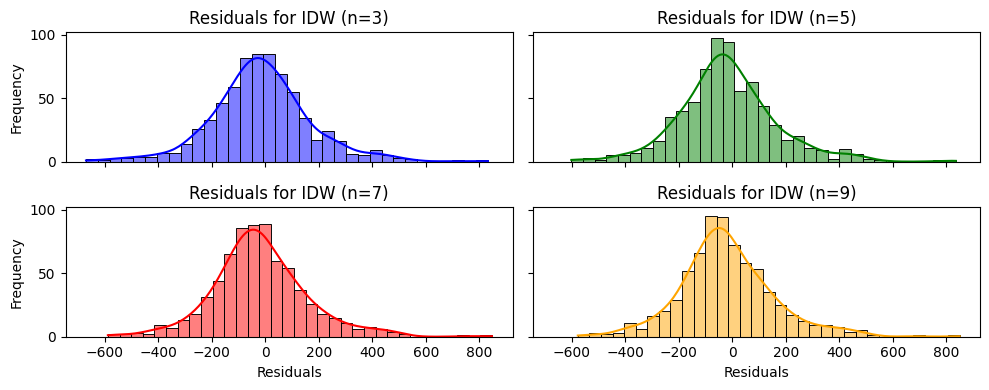

In [25]:
# Calculate residuals
#residuals_idw2 = val_ESA[target] - idw_pred_2
residuals_idw23 = val_ESA[target] - idw_pred_2_3
residuals_idw25 = val_ESA[target] - idw_pred_2_5
residuals_idw27 = val_ESA[target] - idw_pred_2_7
residuals_idw29 = val_ESA[target] - idw_pred_2_9
#residuals_idw211 = val_ESA[target] - idw_pred_2_11

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
axs = ax.flatten()

# n=3, p=2
sns.histplot(residuals_idw23, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Residuals for IDW (n=3)')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# n=5, p=2
sns.histplot(residuals_idw25, kde=True, color='green', ax=axs[1])
axs[1].set_title('Residuals for IDW (n=5)')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# n=7, p=2
sns.histplot(residuals_idw27, kde=True, color='red', ax=axs[2])
axs[2].set_title('Residuals for IDW (n=7)')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

# n=9, p=2
sns.histplot(residuals_idw29, kde=True, color='orange', ax=axs[3])
axs[3].set_title('Residuals for IDW (n=9)')
axs[3].set_xlabel('Residuals')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

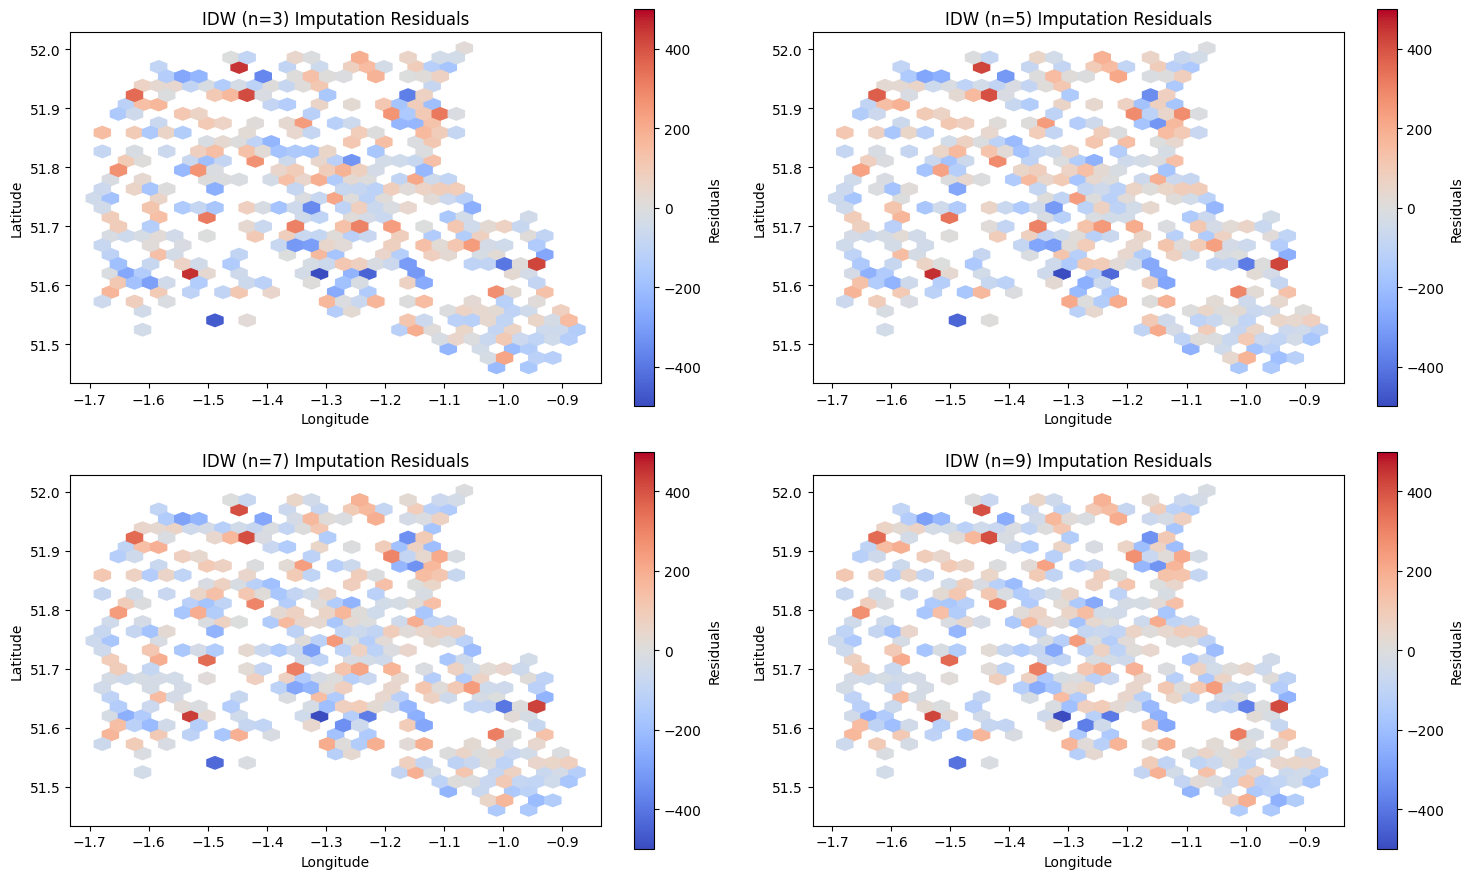

In [26]:
# mapping the residuals
val_ESA['residual_IDW23'] = val_ESA[target] - idw_pred_2_3
val_ESA['residual_IDW25'] = val_ESA[target] - idw_pred_2_5
val_ESA['residual_IDW27'] = val_ESA[target] - idw_pred_2_7
val_ESA['residual_IDW29'] = val_ESA[target] - idw_pred_2_9

# Extract centroids and get the x and y coordinates
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)
x = [centroid.x for centroid in val_centroids]
y = [centroid.y for centroid in val_centroids]

# Citation: Matplotlib, Axes.hexbin. 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hexbin.html

# Create subplots for hexbin plots
fig, axes = plt.subplots(2, 2, figsize=(15, 9), facecolor='white')
cmap='coolwarm'

vmin = -500
vmax = 500

# n=3, p=2
hb_idw2 = axes[0, 0].hexbin(x, y, C=val_ESA['residual_IDW23'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[0, 0].set_title('IDW (n=3) Imputation Residuals')
axes[0, 0].set_aspect('equal', adjustable='box')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')

# n=5, p=2
hb_idw23 = axes[0, 1].hexbin(x, y, C=val_ESA['residual_IDW25'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[0, 1].set_title('IDW (n=5) Imputation Residuals')
axes[0, 1].set_aspect('equal', adjustable='box')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')

# n=7, p=2
hb_idw27 = axes[1, 0].hexbin(x, y, C=val_ESA['residual_IDW27'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[1, 0].set_title('IDW (n=7) Imputation Residuals')
axes[1, 0].set_aspect('equal', adjustable='box')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')

# n=9, p=2
hb_idw29 = axes[1, 1].hexbin(x, y, C=val_ESA['residual_IDW29'], gridsize=30, cmap=cmap, mincnt=1,
                            vmin=vmin, vmax=vmax)
axes[1, 1].set_title('IDW (n=9) Imputation Residuals')
axes[1, 1].set_aspect('equal', adjustable='box')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')

# Add colorbars
fig.colorbar(hb_idw2, ax=axes[0, 0], label='Residuals')
fig.colorbar(hb_idw23, ax=axes[0, 1], label='Residuals')
fig.colorbar(hb_idw27, ax=axes[1, 0], label='Residuals')
fig.colorbar(hb_idw29, ax=axes[1, 1], label='Residuals')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 7. GWR imputation

In [27]:
# Citation: MGWR, GWR. 
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.html

# Extract centroids and values for training data
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_coord_x = [centroid.x for centroid in train_centroids]
train_coord_y = [centroid.y for centroid in train_centroids]
train_coords = np.column_stack([train_coord_x, train_coord_y])
train_target = train_ESA[target].values.reshape((-1, 1))
train_features = train_ESA[conti_features].values

# Extract centroids and values for validation data
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)

val_coord_x = [centroid.x for centroid in val_centroids]
val_coord_y = [centroid.y for centroid in val_centroids]
val_coords = np.column_stack([val_coord_x, val_coord_y])
val_target = val_ESA[target].values.reshape((-1, 1))
val_features = val_ESA[conti_features].values

In [28]:
# Define the list of bandwidth values
bandwidth_values = [50, 100, 200, 400]

# store results
results = {}

# Test each bandwidth with validation set
for bw in bandwidth_values:
    
    # Fit GWR model
    gwr_model = GWR(train_coords, train_target, train_features, bw=bw)
    gwr_results = gwr_model.fit()
    
    # predict for val
    val_gwr_results = gwr_model.predict(val_coords, val_features)
    val_predictions = val_gwr_results.predictions.flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_ESA[target], val_predictions))
    mae  = mean_absolute_error(val_ESA[target], val_predictions)
    mape = mean_absolute_percentage_error(val_ESA[target], val_predictions)*100
    
    # Store results
    results[bw] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Store residuals for plotting
    val_ESA[f'residual_GWR{bw}'] = val_ESA[target] - val_predictions

# Print the results
for bw, metrics in results.items():
    print(f"Bandwidth: {bw}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")

Bandwidth: 50
  RMSE: 187.66
  MAE: 127.49
  MAPE: 147.57%
Bandwidth: 100
  RMSE: 168.47
  MAE: 119.21
  MAPE: 143.51%
Bandwidth: 200
  RMSE: 164.58
  MAE: 116.75
  MAPE: 145.10%
Bandwidth: 400
  RMSE: 165.07
  MAE: 117.63
  MAPE: 151.60%


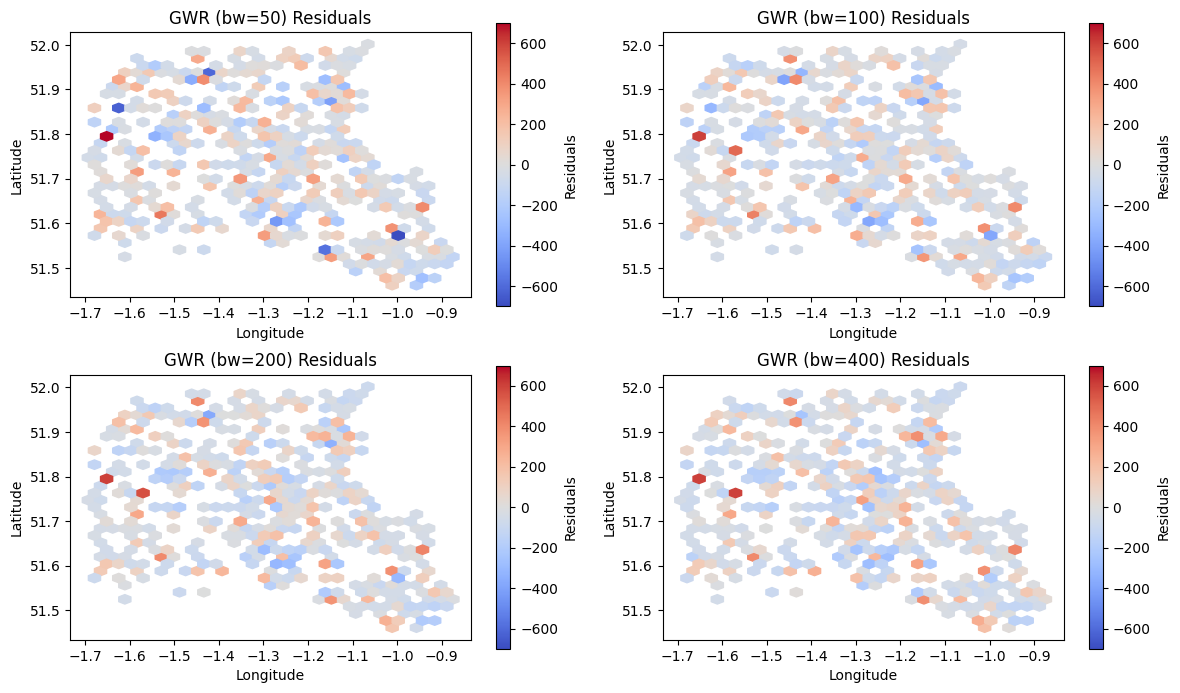

In [29]:
# Extract centroids and get the x and y coordinates
val_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)
x = [centroid.x for centroid in val_centroids]
y = [centroid.y for centroid in val_centroids]

# Create subplots for hexbn plots
fig, axes = plt.subplots(2, 2, figsize=(12, 7), facecolor='white')
cmap = 'coolwarm'
vmin = -700
vmax = 700

# Plot hexbin for each bandwidth residuals
for i, bw in enumerate(bandwidth_values):
    ax = axes[i // 2, i % 2]
    hb = ax.hexbin(x, y, C=val_ESA[f'residual_GWR{bw}'], gridsize=30, cmap=cmap, mincnt=1,
                   vmin=vmin, vmax=vmax)
    ax.set_title(f'GWR (bw={bw}) Residuals')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Add colorbars
for ax in axes.flatten():
    fig.colorbar(ax.collections[0], ax=ax, label='Residuals')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Test set results in differnt methods

In [30]:
## Median imputation
median_value = train_ESA[target].median()
test_capacity = test_ESA[[target]]
test_median_imputed = test_capacity.copy()

# Impute with calculated statistics
test_median_imputed[target] = median_value

# metrics
rmse_median_test, mae_median_test, mape_median_test = evaluate_imputation(test_capacity, test_median_imputed[[target]])

# Print results
print(f"RMSE (Median)  : {rmse_median_test}")
print(f"MAE  (Median)  : {mae_median_test}")
print(f"MAPE (Median)  : {mape_median_test}")

RMSE (Median)  : 266.1434901413761
MAE  (Median)  : 196.3093220338983
MAPE (Median)  : 207.3746749170478


In [31]:
## KNN imputation
# Normalize continuous features
scaler = StandardScaler()
train_conti_scaled = scaler.fit_transform(train_ESA[conti_features])
test_conti_scaled = scaler.transform(test_ESA[conti_features])

# Add the target column to the combined dataset
train_scaled_with_target = np.concatenate([train_conti_scaled, train_ESA[[target]].values.reshape(-1, 1)], axis=1)
test_scaled_with_target = np.concatenate([test_conti_scaled, test_ESA[[target]].values.reshape(-1, 1)], axis=1)

# Convert to DataFrame for easier handling
train_scaled_df = pd.DataFrame(train_scaled_with_target, columns=conti_features + [target])
test_scaled_df = pd.DataFrame(test_scaled_with_target, columns=conti_features + [target])

In [32]:
# Function to perform KNN Imputation
def impute_knn_test(target, n):
    
    # Prepare the val datasets
    test_scaled_df[[target]] = np.nan
    
    # KNN imputation
    imputer = KNNImputer(n_neighbors=n)
    imputer.fit(train_scaled_df)
    test_imputed = imputer.transform(test_scaled_df)
    
    return test_imputed

# Apply the KNN imputer
test_KNN = impute_knn_test(target, 7)

# Convert the imputed numpy array back to a DataFrame for easier comparison
test_KNN_df = pd.DataFrame(test_KNN, columns=conti_features + [target])

In [33]:
rmse_knn_test, mae_knn_test, mape_knn_test = evaluate_imputation(test_ESA[target], test_KNN_df[target])

# Print results
print(f"RMSE (test KNN)  : {rmse_knn_test}")
print(f"MAE  (test KNN)  : {mae_knn_test}")
print(f"MAPE (test KNN)  : {mape_knn_test}")

RMSE (test KNN)  : 169.65484321107385
MAE  (test KNN)  : 117.95803066989507
MAPE (test KNN)  : 118.98590973583407


In [34]:
## Linear regression

test_LR = model2.predict(test_ESA[new_features])

# metrics
rmse_lr_test, mae_lr_test, mape_lr_test = evaluate_imputation(test_ESA[target], test_LR)

# Print results
print(f"RMSE (test LR)  : {rmse_lr_test}")
print(f"MAE  (test LR)  : {mae_lr_test}")
print(f"MAPE (test LR)  : {mape_lr_test}")

RMSE (test LR)  : 196.3539172456369
MAE  (test LR)  : 139.71480765984938
MAPE (test LR)  : 170.5968886161526


In [35]:
## Random Forest
# Prepare test set

X_test = test_ESA[conti_features]
test_RF = rf500_15.predict(X_test)

# metrics
rmse_rf_test, mae_rf_test, mape_rf_test = evaluate_imputation(test_ESA[target], test_RF)

# Print results
print(f"RMSE (test RF)  : {rmse_rf_test}")
print(f"MAE  (test RF)  : {mae_rf_test}")
print(f"MAPE (test RF)  : {mape_rf_test}")

RMSE (test RF)  : 163.9915629691158
MAE  (test RF)  : 112.61977496713264
MAPE (test RF)  : 118.199508862846


In [36]:
## MLP
def impute_mlp_test(hiddensizes, lr):
    
    mlp = MLPRegressor(hidden_layer_sizes=hiddensizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=363, early_stopping=True, validation_fraction=0.1, 
                       learning_rate_init=lr)
    
    # Train the model
    mlp.fit(train_conti_scaled, y_train_scaled.ravel())
    
    # Predict on test data
    y_pred_scaled = mlp.predict(test_conti_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return y_pred

# Apply the MLP imputer
test_MLP = impute_mlp_test((30, 30), 0.05)

# metrics
rmse_mlp_test, mae_mlp_test, mape_mlp_test = evaluate_imputation(test_ESA[target], test_MLP)

# Print results
print(f"RMSE (test MLP)  : {rmse_mlp_test}")
print(f"MAE  (test MLP)  : {mae_mlp_test}")
print(f"MAPE (test MLP)  : {mape_mlp_test}")

RMSE (test MLP)  : 163.76637070283317
MAE  (test MLP)  : 109.7545762500901
MAPE (test MLP)  : 107.64467480642695


In [37]:
## IDW
# Extract centroids and values for training set
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_x = [centroid.x for centroid in train_centroids]
train_y = [centroid.y for centroid in train_centroids]
train_target = train_ESA[target]

# Extract centroids and values for test set
test_centroids = test_ESA['geometry'].apply(lambda geom: geom.centroid)

test_x = [centroid.x for centroid in test_centroids]
test_y = [centroid.y for centroid in test_centroids]
test_target = test_ESA[target]

In [38]:
test_IDW = idw_interpolation(train_x, train_y, train_target, test_x, test_y, power=2, n_neighbors=9)

# metrics
rmse_idw_test, mae_idw_test, mape_idw_test = evaluate_imputation(test_ESA[target], test_IDW)

# Print results
print(f"RMSE (test IDW)  : {rmse_idw_test}")
print(f"MAE  (test IDW)  : {mae_idw_test}")
print(f"MAPE (test IDW)  : {mape_idw_test}")

RMSE (test IDW)  : 180.24371863070556
MAE  (test IDW)  : 134.80243035232328
MAPE (test IDW)  : 164.6922402985579


In [39]:
## GWR
# Extract centroids and values for training set
train_centroids = train_ESA['geometry'].apply(lambda geom: geom.centroid)

train_coord_x = [centroid.x for centroid in train_centroids]
train_coord_y = [centroid.y for centroid in train_centroids]
train_coords = np.column_stack([train_coord_x, train_coord_y])
train_target = train_ESA[target].values.reshape((-1, 1))
train_features = train_ESA[conti_features].values

# Extract centroids and values for test set
test_centroids = val_ESA['geometry'].apply(lambda geom: geom.centroid)

test_coord_x = [centroid.x for centroid in test_centroids]
test_coord_y = [centroid.y for centroid in test_centroids]
test_coords = np.column_stack([test_coord_x, test_coord_y])
test_target = test_ESA[target].values.reshape((-1, 1))
test_features = test_ESA[conti_features].values

In [40]:
gwr_model = GWR(train_coords, train_target, train_features, bw=200)
gwr_results = gwr_model.fit()
    
# predict for test set
test_gwr_results = gwr_model.predict(test_coords, test_features)
test_GWR = test_gwr_results.predictions.flatten()

# metrics
rmse_gwr_test, mae_gwr_test, mape_gwr_test = evaluate_imputation(test_ESA[target], test_GWR)

# Print results
print(f"RMSE (test GWR)  : {rmse_gwr_test}")
print(f"MAE  (test GWR)  : {mae_gwr_test}")
print(f"MAPE (test GWR)  : {mape_gwr_test}")

RMSE (test GWR)  : 246.16178634556675
MAE  (test GWR)  : 166.63620170129036
MAPE (test GWR)  : 201.47359985784456


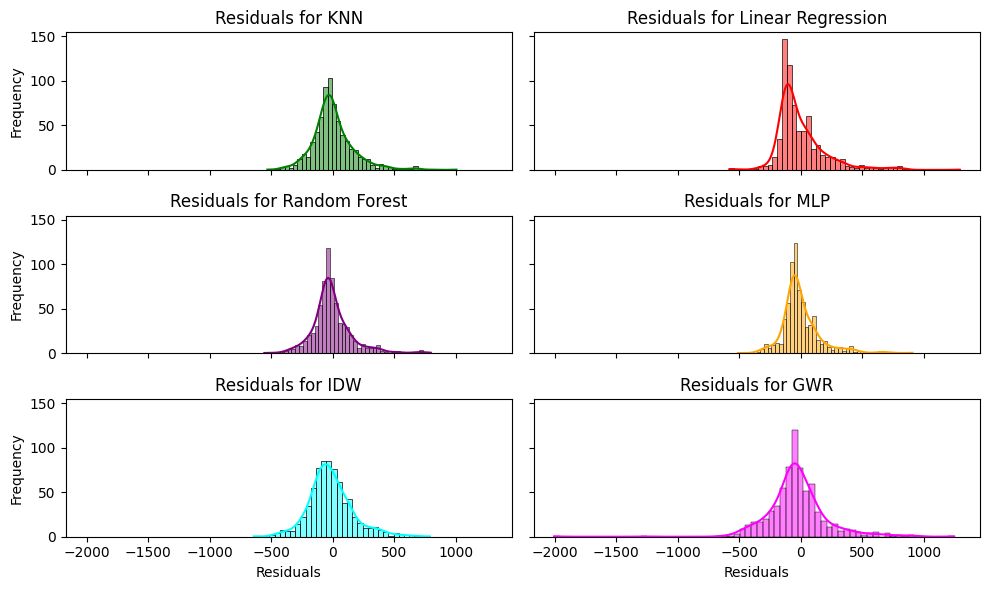

In [41]:
# Calculate residuals for different models
target = 'CapacityRating'
residuals_test_median = test_ESA[target] - test_median_imputed[target]
residuals_test_KNN = test_ESA[target] - test_KNN_df[target]
residuals_test_LR = test_ESA[target] - test_LR.ravel()
residuals_test_RF = test_ESA[target] - test_RF.ravel()
residuals_test_MLP = test_ESA[target] - test_MLP.ravel()
residuals_test_IDW = test_ESA[target] - test_IDW.ravel()
residuals_test_GWR = test_ESA[target] - test_GWR.ravel()

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)

# KNN
sns.histplot(residuals_test_KNN, kde=True, color='green', ax=axs[0, 0])
axs[0, 0].set_title('Residuals for KNN')
axs[0, 0].set_xlabel('Residuals')
axs[0, 0].set_ylabel('Frequency')

# Linear Regression
sns.histplot(residuals_test_LR, kde=True, color='red', ax=axs[0, 1])
axs[0, 1].set_title('Residuals for Linear Regression')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Frequency')

# Random Forest
sns.histplot(residuals_test_RF, kde=True, color='purple', ax=axs[1, 0])
axs[1, 0].set_title('Residuals for Random Forest')
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency')

# MLP
sns.histplot(residuals_test_MLP, kde=True, color='orange', ax=axs[1, 1])
axs[1, 1].set_title('Residuals for MLP')
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylabel('Frequency')

# IDW
sns.histplot(residuals_test_IDW, kde=True, color='cyan', ax=axs[2, 0])
axs[2, 0].set_title('Residuals for IDW')
axs[2, 0].set_xlabel('Residuals')
axs[2, 0].set_ylabel('Frequency')

# GWR
sns.histplot(residuals_test_GWR, kde=True, color='magenta', ax=axs[2, 1])
axs[2, 1].set_title('Residuals for GWR')
axs[2, 1].set_xlabel('Residuals')
axs[2, 1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()
